In [2]:
import geopandas as gpd
import cartopy.crs as ccrs
from shapely import Point
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import numpy as np
from tqdm import tqdm
import rioxarray as rio
import xarray as xr
from glob import glob
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
tqdm.pandas()
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

In [3]:
prj = ccrs.AzimuthalEquidistant(central_latitude=-16, central_longitude=172.75)

world = (gpd.read_file('../day3_polygons/ne_10m_admin_0_countries.zip'))
                        #  where="REGION_UN = 'Oceania'"))

## because there are two polygons for the oceans
oceans = (gpd.read_file('../day3_polygons/ne_10m_ocean.zip'))
ocean = gpd.GeoDataFrame(geometry=[oceans['geometry'][0].geoms[0]], crs=4326)

# quarter of the way round the world : useful flor clipping Aziumuthal equidistant projections
qm = 10_001_965.729
quarter_meridian_away = gpd.GeoSeries(Point(0,0).buffer(qm),crs=prj)

## clip the world
world_clipped = (world.explode(index_parts=False)
                 .to_crs(prj)
                 .clip(quarter_meridian_away))

## clip the ocean
ocean_clipped = (ocean.explode(index_parts=False)
                 .to_crs(prj)
                 .clip(quarter_meridian_away))


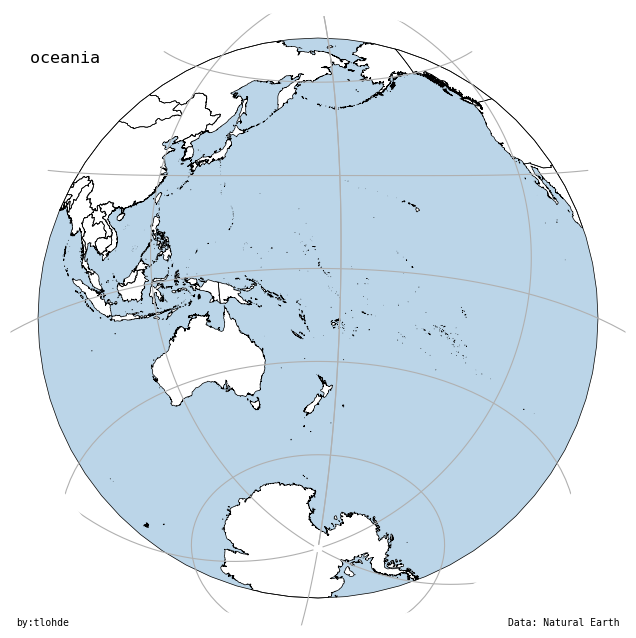

In [33]:
fig, ax = plt.subplots(figsize=[8,8],
                       subplot_kw={'projection':prj})

ocean_clipped.plot(alpha=0.3, ax=ax, ec='none')

world_clipped.plot(fc='none',linewidth=0.5,ax=ax)

ax.gridlines(ccrs.PlateCarree())

# force axes to be circular
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_axis_off()

ax.set_title('  oceania', loc='left', y=0.9)

ax.annotate(text='Data: Natural Earth',
            xy=(0.99,0), 
            xycoords='axes fraction', 
            ha='right',
            fontsize=7)

ax.annotate(text='by:tlohde',
            xy=(0.01,0), 
            xycoords='axes fraction',
            ha='left',
            fontsize=7)

fig.savefig('day16.png', dpi=300, bbox_inches='tight')

#### stuff that didn't happen

In [5]:
### getting bathymmetry from open topo API
## URI too long...can't be bothered to work out how to split it up...
import requests

minx,miny,maxx,maxy = ocean_clipped.total_bounds
xs = np.linspace(minx,maxx,50)
ys = np.linspace(miny,maxy,50)
points = gpd.GeoDataFrame(geometry=[Point(p) for p in product(xs,ys)], crs=prj).clip(ocean_clipped)

url = 'https://api.opentopodata.org/v1/gebco2020'
params = {'locations':'-68.42708,39.22408'}
coords = points.to_crs(4326)['geometry'].apply(lambda q: f'{q.y},{q.x}').tolist()
response = requests.get(url,params={'locations':'|'.join(coords[0:40])})

In [ ]:
### getting distance from point to nearest coast
### - would work were it not for the pesky seam at (-)180 degrees

lons = np.concatenate([np.arange(100,181,3),
                       np.arange(-180,100,3)])
lats = np.arange(-89,89,3)

points = gpd.GeoSeries([Point(p) for p in (product(lons,lats))], crs=4326)
points = (points.clip(ocean)
          .to_crs(prj)
          .clip(quarter_meridian_away))

ps = gpd.GeoDataFrame(geometry=points, crs=prj).to_crs(4326)
ps['x'] = np.round(ps['geometry'].x)
ps['y'] = np.round(ps['geometry'].y)

ps['aeqd_prj'] = ps[['x','y']].progress_apply(lambda q: ccrs.AzimuthalEquidistant(central_latitude=q.y,
                                                                                  central_longitude=q.x),
                                              axis=1)

dask_ps = dd.from_pandas(ps[['x','y','aeqd_prj']], npartitions=4)

def distance_to_land(_prj):
    coast = ocean.to_crs(_prj)['geometry']
    return min([geom.exterior.distance(Point(0,0)) for geom in oceans.to_crs(_prj)['geometry'][0].geoms])

dask_ps['distance_to_land'] = dask_ps.apply(lambda q: distance_to_land(q.aeqd_prj),
                                            axis=1,
                                            meta=('distance_to_land', 'f8'))

out = dask_ps.compute()

ocean_points = gpd.GeoDataFrame(out, geometry=gpd.points_from_xy(out['x'], out['y'],
                                                                 crs=4326), crs=4326)
ocean_points['distance (km)'] = ocean_points['distance_to_land']/1000

# ocean_points[['x','y','geometry','distance_to_land', 'distance (km)']].to_feather('ocean_points.feather')

In [ ]:
(ocean_points
 .to_crs(prj)
 .clip(quarter_meridian_away)
 .plot(column='distance (km)',
       markersize=1,
       cmap='Blues',
       vmin=0,
       vmax=ocean_points['distance (km)'].max(),
       legend=False,
       ax=ax))

cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=0,
                                                vmax=ocean_points['distance (km)'].max()),
                                 cmap = 'Blues'),
                  ax=ax,
                  location='bottom',
                  shrink=0.7,
                  pad=0.05,
                  )
cb.outline.set_visible(False)
cb.ax.set_title('<-- distance from land (km) -->')

In [ ]:
### bathymmetry from GEBCO
# fs = glob('GEBCO_16_Nov_2023_91efd1d5ced7/GEBCO_16_Nov_2023_91efd1d5ced7/*.tif')
# for f in fs:
#     with rio.open_rasterio(f, decode_coords=True, chunks='auto') as b:
#         (b[0,:,:]
#          .coarsen({'x':10,'y':10},
#                   boundary='trim')
#          .mean()
#          .rio.write_crs(b.rio.crs)
#          .rio.reproject(prj,
#                         nodata=np.nan)
#          .plot(ax=ax,
#                add_colorbar=False))